In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from torchvision.models import resnet50, ResNet50_Weights
import torchvision

In [ ]:
DATADIR = "/home/khushi/Testing_testing/Data/Updated_Data"
categories = ["Anaesthesia_machine","baby_incubator","Bone_saws","C_arm","colonoscope","Curved_Mayo_Scissor","difibrillator","Electrocautery_devices","fetal_doppler","forceps","Heart_Lung_Machine","IABP","IMRT","infusion_pump","Laryngoscopes","mayfield_clamp","Needle_Biopsy_Device","phacoemulsification","Radiofrequency_Ablation_Device","Scalpel","Straight_Dissection_Clamp","Straight_Mayo_Scissor","Suction_Machine","ventilator","x_ray"]
input_size = (224, 224)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, categories, input_size, transform=None):
        self.data_dir = data_dir
        self.categories = categories
        self.input_size = input_size
        self.transform = transform
        self.data = []
        self.labels = []
        self.load_data()

    def load_data(self):
        for cat in self.categories:
            path = os.path.join(self.data_dir, cat)
            class_num = self.categories.index(cat)
            for img_name in os.listdir(path):
                try:
                    img_path = os.path.join(path, img_name)
                    img = Image.open(img_path).convert("RGB")
                    img = img.resize(self.input_size)
                    if self.transform:
                        img = self.transform(img)
                    self.data.append(img)
                    self.labels.append(class_num)
                except Exception as e:
                    pass

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        return img, label

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
   
])

dataset = CustomDataset(DATADIR, categories, input_size, transform=transform)

train_size = int(0.80 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [ ]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [53]:
import torch.nn as nn
import torchvision.models as models
'''
class CustomResNet(nn.Module):
    def __init__(self, num_classes, fine_tune_layers=3):
        super(CustomResNet, self).__init__()
        res = models.resnet34(pretrained=True)
        self.res = nn.Sequential(*list(res.children())[:-1])

        # Freeze all layers by default
        for param in res.parameters():
            param.requires_grad = True
        

        # Define your custom layers
        self.convlayers = nn.Sequential(
            nn.Conv2d(512,2048, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(2048, 2048, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv2d(2048, 1024, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.BatchNorm2d(1024),
            nn.Dropout(0.5),
            nn.Conv2d(1024, 1024, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(1024,512, kernel_size=1),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Conv2d(512,64, kernel_size=1),
            nn.ReLU(),
            
            nn.Linear(64, num_classes)  # Adjust the output size to match the number of classes
        )

    def forward(self, x):
        x = self.res(x)
        x = self.convlayers(x)
        return x
'''

class CustomResNet(nn.Module):
    def __init__(self, num_classes, fine_tune_layers=3):
        super(CustomResNet, self).__init__()
        res = models.resnet34(pretrained=True)
        self.res = nn.Sequential(*list(res.children())[:-2])

        # Freeze all layers by default
        for param in res.parameters():
            param.requires_grad = False

        # Define your custom layers
        self.convlayers = nn.Sequential(
            nn.Conv2d(512, 2048, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(2048),
            nn.Dropout(0.5),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling layer added
            
            nn.Conv2d(2048, 1024, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            nn.Conv2d(1024, 512, kernel_size=3, padding=1, stride=1),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.Dropout(0.5),
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 3 * 3, 126),  # Adjust the output size after max pooling
            nn.ReLU(),            
            nn.Linear(126, num_classes),
        )

    def forward(self, x):
        x = self.res(x)
        x = self.convlayers(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor to [batch_size, num_features]
        x = self.fc_layers(x)
        return x

       


In [54]:

num_classes = len(categories)
model = CustomResNet(num_classes).to(device)
# for name, param in model.named_parameters():
#     print(f"{name}: requires_grad={param.requires_grad}")

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

train_acc_history=[]
test_acc_history=[]
test_loss_history=[]
train_loss_history=[]

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00105, weight_decay=1e-5)

# Define the number of epochs and early stopping parameters
num_epochs = 25
patience = 5
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    model.train()
    train_loss, train_corrects = 0.0, 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        labels = torch.squeeze(labels)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels).item()

    train_loss = train_loss / len(train_dataset)
    train_acc = train_corrects / len(train_dataset)
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss)

    model.eval()
    val_loss, val_corrects = 0.0, 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels).item()

        val_loss = val_loss / len(test_dataset)
        val_acc = val_corrects / len(test_dataset)

        test_acc_history.append(val_acc)
        test_loss_history.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            # Save the best model if needed
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping! No improvement in {patience} epochs.")
                break


Epoch 1/25 | Train Loss: 2.2758 | Train Acc: 0.2823 | Val Loss: 14.4269 | Val Acc: 0.3096
Epoch 2/25 | Train Loss: 1.4848 | Train Acc: 0.5246 | Val Loss: 11.7626 | Val Acc: 0.4341
Epoch 3/25 | Train Loss: 1.0629 | Train Acc: 0.6622 | Val Loss: 10.9440 | Val Acc: 0.5115
Epoch 4/25 | Train Loss: 0.8445 | Train Acc: 0.7342 | Val Loss: 16.0683 | Val Acc: 0.5262
Epoch 5/25 | Train Loss: 0.7124 | Train Acc: 0.7737 | Val Loss: 13.0875 | Val Acc: 0.5533
Epoch 6/25 | Train Loss: 0.5984 | Train Acc: 0.8111 | Val Loss: 16.6732 | Val Acc: 0.5303
Epoch 7/25 | Train Loss: 0.4527 | Train Acc: 0.8522 | Val Loss: 36.0037 | Val Acc: 0.4592
Epoch 8/25 | Train Loss: 0.4062 | Train Acc: 0.8666 | Val Loss: 29.2487 | Val Acc: 0.4874
Early stopping! No improvement in 5 epochs.


ValueError: x and y must have same first dimension, but have shapes (25,) and (8,)

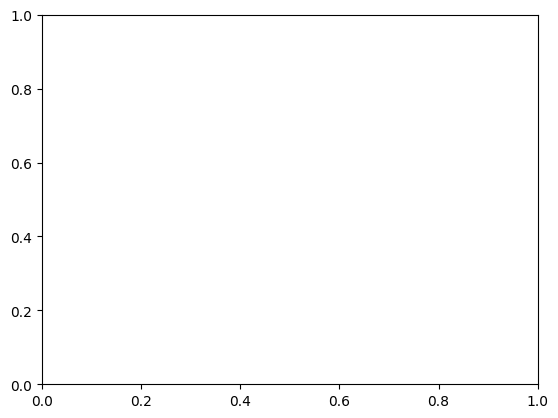

In [56]:
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs+1), train_acc_history, label='Train')
plt.plot(range(1, num_epochs+1), test_acc_history, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(range(1, num_epochs+1), train_loss_history, label='Train')
plt.plot(range(1, num_epochs+1), test_loss_history, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from torchvision import transforms
from PIL import Image

# Load the custom ResNet model
model = CustomResNet(num_classes=len(categories))  # Replace NUM_CLASSES with the number of classes in your dataset

# Load the pre-trained weights (if any)
# If you have saved your model state_dict, you can load it using:
# model.load_state_dict(torch.load('path_to_your_model_weights.pth'))
# Otherwise, you can skip this step if you trained the model in the same session

# Set the model to evaluation mode
model.eval()

# Load and preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the image using PIL
image = Image.open("/home/khushi/Testing_testing/Data/Updated_Data/Straight_Mayo_Scissor/tesourareta4_resized_.jpeg")
# Preprocess the image
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Make predictions
with torch.no_grad():
    output = model(input_tensor)
    probabilities = torch.softmax(output, dim=1)

# Get the predicted class index
predicted_class_index = torch.argmax(probabilities, dim=1).item()

# Optionally, get the class label based on the index
# Assuming you have a list of class labels
class_labels = categories  # Replace with your actual class labels
predicted_class_label = class_labels[predicted_class_index]

print("Predicted Class Index:", predicted_class_index)
print("Predicted Class Label:", predicted_class_label)
print("Class Probabilities:", probabilities)
